In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-27 00:02:54.567249


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v3" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v3"]).reset_index(drop=True)

df_review:
source                      0
hotel_id                    0
hotel_name                  0
country                     0
group_name                  0
room_type                   0
stay_length                 0
stay_date                   0
review_score                0
review_score_category       0
sentiment                   0
review_date                 0
review_title                1
review                      0
review_cleaned_v1           0
review_cleaned_v2           0
review_cleaned_v3        1635
dtype: int64
Total rows in df_review: 39602 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.10  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,165,524,689
2023,522,2023,2545
2024,108,455,563
Total,795,3002,3797


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:40<05:27, 40.91s/it]

Topic #1:
0.360*"great" + 0.221*"station" + 0.193*"breakfast" + 0.188*"food" + 0.184*"friendly" + 0.155*"singapore" + 0.148*"water" + 0.141*"provide" + 0.137*"service" + 0.136*"helpful" + 0.127*"really" + 0.122*"walk" + 0.121*"overall" + 0.119*"close" + 0.117*"comfortable" + 0.115*"bathroom" + 0.108*"price" + 0.102*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.830*"great" + 0.204*"water" + 0.110*"call" + 0.104*"provide" + 0.102*"want" + -0.098*"friendly" + 0.097*"tell" + 0.091*"reception" + 0.088*"station" + 0.078*"quite" + 0.076*"shower" + 0.069*"first" + 0.068*"still" + 0.067*"bathroom" + 0.065*"toilet" + 0.065*"wait" + 0.064*"find" + 0.062*"really" + 0.061*"change" + 0.058*"request"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [01:30<05:22, 46.04s/it]

Topic #1:
0.359*"great" + 0.224*"station" + 0.193*"breakfast" + 0.189*"food" + 0.183*"friendly" + 0.155*"singapore" + 0.147*"water" + 0.141*"provide" + 0.136*"service" + 0.136*"helpful" + 0.127*"really" + 0.122*"walk" + 0.121*"overall" + 0.120*"close" + 0.117*"comfortable" + 0.114*"bathroom" + 0.108*"price" + 0.102*"restaurant" + 0.102*"shower" + 0.101*"facility"

Topic #2:
-0.846*"great" + 0.224*"station" + 0.165*"water" + 0.117*"food" + -0.097*"friendly" + 0.088*"bus" + 0.079*"quite" + 0.075*"provide" + 0.068*"want" + 0.066*"close" + 0.064*"bathroom" + 0.061*"singapore" + 0.060*"shower" + 0.059*"call" + 0.058*"find" + 0.055*"lot" + 0.055*"space" + 0.052*"reception" + 0.052*"still" + 0.051*"toilet"

Topic #3:
0.600*"station" + 0.255*"food" + -0.216*"water" + -0.180*"call" + 0.164*"bus" + -0.161*"tell" + -0.145*"reception" + -0.140*"provide" + 0.139*"walk" + -0.139*"service" + 0.128*"mind" + -0.124*"want" + -0.104*"request" + -0.103*"work" + -0.100*"wait" + -0.096*"really" + 0.093*"clo

 33%|████████████████████████████                                                        | 3/9 [02:20<04:48, 48.01s/it]

Topic #1:
0.360*"great" + 0.224*"station" + 0.190*"breakfast" + 0.188*"food" + 0.183*"friendly" + 0.154*"singapore" + 0.150*"water" + 0.141*"provide" + 0.135*"helpful" + 0.135*"service" + 0.127*"really" + 0.122*"walk" + 0.121*"overall" + 0.119*"close" + 0.117*"comfortable" + 0.115*"bathroom" + 0.108*"price" + 0.103*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.842*"great" + 0.222*"station" + 0.180*"water" + 0.109*"food" + -0.097*"friendly" + 0.086*"bus" + 0.081*"quite" + 0.079*"provide" + 0.068*"bathroom" + 0.068*"want" + 0.066*"shower" + 0.064*"close" + 0.059*"singapore" + 0.057*"find" + 0.057*"call" + 0.056*"space" + 0.056*"lot" + 0.055*"toilet" + 0.053*"reception" + 0.052*"still"

Topic #3:
0.594*"station" + 0.269*"food" + -0.245*"water" + -0.174*"call" + 0.165*"bus" + -0.154*"tell" + -0.144*"reception" + -0.144*"provide" + 0.136*"walk" + 0.128*"mind" + -0.126*"service" + -0.121*"want" + -0.106*"work" + -0.103*"shower" + -0.100*"request" + -0.099*"really" + -0.095*"

 44%|█████████████████████████████████████▎                                              | 4/9 [03:09<04:01, 48.24s/it]

Topic #1:
0.359*"great" + 0.224*"station" + 0.191*"breakfast" + 0.185*"food" + 0.185*"friendly" + 0.155*"singapore" + 0.150*"water" + 0.142*"provide" + 0.136*"helpful" + 0.135*"service" + 0.127*"really" + 0.122*"overall" + 0.122*"walk" + 0.119*"close" + 0.117*"comfortable" + 0.116*"bathroom" + 0.109*"price" + 0.103*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.846*"great" + 0.197*"station" + 0.172*"water" + -0.117*"friendly" + 0.087*"food" + 0.085*"quite" + 0.084*"bus" + 0.084*"provide" + 0.075*"want" + 0.071*"singapore" + 0.067*"shower" + 0.065*"bathroom" + 0.063*"call" + 0.060*"find" + 0.056*"close" + 0.055*"space" + 0.055*"reception" + 0.053*"toilet" + 0.052*"still" + 0.052*"tell"

Topic #3:
0.613*"station" + 0.314*"food" + -0.179*"water" + 0.162*"bus" + -0.157*"call" + -0.151*"provide" + -0.144*"service" + -0.140*"tell" + 0.133*"walk" + 0.127*"mind" + -0.124*"reception" + 0.114*"close" + -0.111*"want" + -0.110*"breakfast" + -0.100*"work" + -0.093*"really" + -0.091*

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:58<03:14, 48.66s/it]

Topic #1:
0.358*"great" + 0.224*"station" + 0.191*"breakfast" + 0.185*"food" + 0.185*"friendly" + 0.155*"singapore" + 0.150*"water" + 0.142*"provide" + 0.136*"helpful" + 0.135*"service" + 0.128*"really" + 0.122*"overall" + 0.122*"walk" + 0.119*"close" + 0.117*"comfortable" + 0.116*"bathroom" + 0.109*"price" + 0.103*"shower" + 0.101*"restaurant" + 0.101*"facility"

Topic #2:
-0.849*"great" + 0.187*"station" + 0.181*"water" + -0.113*"friendly" + 0.089*"food" + 0.088*"provide" + 0.085*"quite" + 0.081*"bus" + 0.074*"want" + 0.069*"shower" + 0.067*"singapore" + 0.066*"bathroom" + 0.062*"call" + 0.058*"find" + 0.055*"toilet" + 0.055*"space" + 0.053*"reception" + 0.053*"close" + 0.053*"really" + 0.052*"still"

Topic #3:
0.615*"station" + 0.301*"food" + -0.200*"water" + -0.171*"provide" + 0.160*"bus" + -0.144*"call" + -0.137*"service" + -0.131*"really" + 0.129*"walk" + -0.125*"tell" + 0.124*"close" + 0.118*"mind" + -0.115*"reception" + -0.105*"breakfast" + -0.098*"work" + -0.096*"want" + 0.092

 67%|████████████████████████████████████████████████████████                            | 6/9 [04:48<02:27, 49.13s/it]

Topic #1:
0.357*"great" + 0.224*"station" + 0.192*"breakfast" + 0.187*"friendly" + 0.186*"food" + 0.153*"singapore" + 0.150*"water" + 0.141*"provide" + 0.138*"helpful" + 0.135*"service" + 0.129*"really" + 0.122*"overall" + 0.122*"walk" + 0.119*"close" + 0.118*"comfortable" + 0.115*"bathroom" + 0.109*"price" + 0.102*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.853*"great" + 0.188*"station" + 0.173*"water" + -0.091*"friendly" + 0.088*"food" + 0.086*"provide" + 0.083*"quite" + 0.081*"bus" + 0.073*"want" + 0.070*"bathroom" + 0.069*"shower" + 0.066*"singapore" + 0.062*"call" + 0.059*"find" + 0.059*"reception" + 0.055*"toilet" + 0.054*"space" + 0.054*"close" + 0.052*"still" + 0.051*"really"

Topic #3:
0.614*"station" + 0.298*"food" + -0.208*"water" + -0.173*"provide" + 0.158*"bus" + -0.145*"call" + -0.138*"service" + -0.131*"really" + 0.129*"walk" + -0.125*"tell" + 0.124*"close" + 0.118*"mind" + -0.116*"breakfast" + -0.109*"reception" + -0.099*"work" + -0.096*"want" + 0.091

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:41<01:40, 50.19s/it]

Topic #1:
0.357*"great" + 0.224*"station" + 0.192*"breakfast" + 0.187*"friendly" + 0.186*"food" + 0.153*"singapore" + 0.150*"water" + 0.142*"provide" + 0.138*"helpful" + 0.135*"service" + 0.129*"really" + 0.122*"overall" + 0.121*"walk" + 0.119*"close" + 0.118*"comfortable" + 0.115*"bathroom" + 0.109*"price" + 0.102*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.853*"great" + 0.186*"station" + 0.173*"water" + -0.096*"friendly" + 0.088*"provide" + 0.088*"food" + 0.084*"quite" + 0.079*"bus" + 0.072*"want" + 0.071*"shower" + 0.071*"bathroom" + 0.069*"singapore" + 0.061*"call" + 0.059*"reception" + 0.058*"find" + 0.057*"toilet" + 0.056*"space" + 0.054*"close" + 0.052*"still" + 0.050*"tell"

Topic #3:
0.623*"station" + 0.287*"food" + -0.199*"water" + -0.169*"provide" + 0.163*"bus" + -0.138*"call" + -0.136*"service" + 0.134*"walk" + -0.124*"really" + 0.124*"close" + 0.122*"mind" + -0.118*"tell" + -0.109*"reception" + -0.102*"breakfast" + -0.101*"shower" + -0.101*"work" + 0.095

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:34<00:51, 51.20s/it]

Topic #1:
0.357*"great" + 0.225*"station" + 0.193*"breakfast" + 0.187*"friendly" + 0.185*"food" + 0.152*"singapore" + 0.149*"water" + 0.141*"provide" + 0.137*"helpful" + 0.135*"service" + 0.128*"really" + 0.122*"walk" + 0.122*"overall" + 0.119*"close" + 0.118*"comfortable" + 0.115*"bathroom" + 0.109*"price" + 0.102*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.853*"great" + 0.186*"station" + 0.170*"water" + -0.096*"friendly" + 0.089*"food" + 0.088*"provide" + 0.085*"quite" + 0.078*"bus" + 0.071*"want" + 0.071*"bathroom" + 0.071*"shower" + 0.067*"singapore" + 0.061*"call" + 0.059*"reception" + 0.058*"find" + 0.057*"toilet" + 0.056*"space" + 0.055*"close" + 0.052*"still" + 0.050*"tell"

Topic #3:
0.622*"station" + 0.286*"food" + -0.209*"water" + -0.170*"provide" + 0.161*"bus" + 0.140*"walk" + -0.137*"call" + -0.136*"service" + -0.131*"really" + 0.126*"mind" + 0.124*"close" + -0.116*"tell" + -0.112*"reception" + -0.100*"shower" + -0.100*"work" + 0.096*"restaurant" + -0.09

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:30<00:00, 50.03s/it]


Topic #1:
0.357*"great" + 0.225*"station" + 0.194*"breakfast" + 0.187*"friendly" + 0.185*"food" + 0.152*"singapore" + 0.149*"water" + 0.142*"provide" + 0.137*"helpful" + 0.135*"service" + 0.127*"really" + 0.122*"walk" + 0.122*"overall" + 0.119*"close" + 0.118*"comfortable" + 0.116*"bathroom" + 0.108*"price" + 0.103*"shower" + 0.102*"restaurant" + 0.101*"facility"

Topic #2:
-0.854*"great" + 0.187*"station" + 0.171*"water" + -0.091*"friendly" + 0.090*"provide" + 0.087*"food" + 0.085*"quite" + 0.078*"bus" + 0.073*"bathroom" + 0.072*"want" + 0.071*"shower" + 0.066*"singapore" + 0.062*"call" + 0.058*"find" + 0.058*"toilet" + 0.057*"reception" + 0.055*"close" + 0.055*"space" + 0.052*"still" + 0.051*"tell"

Topic #3:
0.617*"station" + 0.291*"food" + -0.209*"water" + -0.173*"provide" + 0.160*"bus" + 0.143*"walk" + -0.137*"call" + -0.136*"service" + -0.128*"really" + 0.127*"mind" + 0.125*"close" + -0.115*"tell" + -0.113*"reception" + -0.102*"shower" + -0.102*"work" + -0.095*"breakfast" + 0.093

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:05<00:41,  5.15s/it]

Topic #1:
0.017*"food" + 0.016*"singapore" + 0.015*"station" + 0.015*"friendly" + 0.014*"breakfast" + 0.014*"helpful" + 0.013*"great" + 0.011*"water" + 0.010*"pool" + 0.009*"close" + 0.009*"provide" + 0.008*"bus" + 0.008*"spacious" + 0.008*"bathroom" + 0.008*"service" + 0.008*"city" + 0.008*"convenient" + 0.007*"walk" + 0.007*"shower" + 0.007*"perfect"

Topic #2:
0.032*"great" + 0.016*"friendly" + 0.015*"station" + 0.013*"comfortable" + 0.012*"facility" + 0.012*"really" + 0.011*"overall" + 0.011*"service" + 0.010*"price" + 0.010*"breakfast" + 0.009*"helpful" + 0.008*"walk" + 0.008*"lot" + 0.007*"bathroom" + 0.007*"everything" + 0.007*"look" + 0.007*"restaurant" + 0.007*"work" + 0.007*"close" + 0.007*"definitely"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:10<00:36,  5.18s/it]

Topic #1:
0.025*"great" + 0.018*"really" + 0.017*"service" + 0.012*"water" + 0.011*"everything" + 0.011*"provide" + 0.011*"friendly" + 0.010*"breakfast" + 0.009*"helpful" + 0.008*"comfortable" + 0.008*"request" + 0.008*"shower" + 0.008*"first" + 0.008*"thank" + 0.008*"big" + 0.008*"enough" + 0.008*"quite" + 0.008*"thing" + 0.007*"toilet" + 0.007*"bathroom"

Topic #2:
0.031*"great" + 0.021*"station" + 0.017*"breakfast" + 0.015*"food" + 0.014*"singapore" + 0.014*"walk" + 0.013*"close" + 0.011*"price" + 0.011*"recommend" + 0.010*"friendly" + 0.010*"lot" + 0.010*"pool" + 0.009*"helpful" + 0.009*"view" + 0.009*"comfortable" + 0.009*"facility" + 0.008*"city" + 0.008*"use" + 0.008*"convenient" + 0.007*"mind"

Topic #3:
0.028*"friendly" + 0.019*"station" + 0.017*"helpful" + 0.016*"many" + 0.015*"food" + 0.011*"restaurant" + 0.011*"comfortable" + 0.011*"bathroom" + 0.010*"overall" + 0.010*"facility" + 0.010*"bus" + 0.009*"great" + 0.009*"convenient" + 0.008*"price" + 0.008*"perfect" + 0.008*"mu

 33%|████████████████████████████                                                        | 3/9 [00:15<00:29,  4.95s/it]

Topic #1:
0.043*"great" + 0.021*"friendly" + 0.016*"helpful" + 0.014*"city" + 0.014*"comfortable" + 0.013*"facility" + 0.013*"station" + 0.012*"provide" + 0.011*"pool" + 0.011*"bathroom" + 0.011*"breakfast" + 0.010*"use" + 0.009*"definitely" + 0.009*"locate" + 0.008*"singapore" + 0.008*"price" + 0.008*"budget" + 0.007*"excellent" + 0.007*"food" + 0.007*"amazing"

Topic #2:
0.025*"great" + 0.024*"friendly" + 0.022*"close" + 0.020*"station" + 0.019*"service" + 0.018*"food" + 0.017*"breakfast" + 0.015*"price" + 0.014*"walk" + 0.014*"mind" + 0.010*"convenient" + 0.010*"helpful" + 0.008*"find" + 0.008*"comfortable" + 0.008*"singapore" + 0.007*"view" + 0.007*"spacious" + 0.007*"restaurant" + 0.006*"recommend" + 0.006*"free"

Topic #3:
0.023*"station" + 0.022*"great" + 0.016*"everything" + 0.015*"thank" + 0.012*"service" + 0.012*"water" + 0.012*"reception" + 0.011*"restaurant" + 0.010*"walk_distance" + 0.010*"experience" + 0.010*"love" + 0.009*"breakfast" + 0.009*"solo" + 0.009*"perfect" + 0.

 44%|█████████████████████████████████████▎                                              | 4/9 [00:19<00:23,  4.77s/it]

Topic #1:
0.025*"great" + 0.019*"breakfast" + 0.015*"service" + 0.013*"lot" + 0.013*"provide" + 0.013*"friendly" + 0.011*"food" + 0.011*"work" + 0.011*"quite" + 0.011*"station" + 0.010*"comfortable" + 0.008*"excellent" + 0.008*"luggage" + 0.007*"use" + 0.007*"city" + 0.007*"much" + 0.007*"help" + 0.007*"smell" + 0.007*"water" + 0.007*"walk"

Topic #2:
0.018*"breakfast" + 0.017*"comfortable" + 0.017*"great" + 0.015*"price" + 0.015*"station" + 0.015*"mind" + 0.014*"walk" + 0.014*"bathroom" + 0.013*"love" + 0.012*"spacious" + 0.012*"toilet" + 0.010*"perfect" + 0.010*"water" + 0.009*"shower" + 0.009*"helpful" + 0.009*"close" + 0.009*"value_money" + 0.009*"use" + 0.008*"singapore" + 0.008*"everything"

Topic #3:
0.034*"great" + 0.020*"helpful" + 0.019*"singapore" + 0.018*"really" + 0.015*"overall" + 0.015*"service" + 0.015*"food" + 0.014*"friendly" + 0.013*"restaurant" + 0.012*"city" + 0.011*"many" + 0.010*"experience" + 0.010*"convenient" + 0.010*"comfortable" + 0.010*"love" + 0.010*"defin

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:23<00:18,  4.65s/it]

Topic #1:
0.030*"water" + 0.018*"station" + 0.015*"singapore" + 0.014*"close" + 0.013*"food" + 0.013*"great" + 0.012*"lot" + 0.011*"shower" + 0.011*"bus_stop" + 0.011*"away" + 0.010*"restaurant" + 0.009*"okay" + 0.009*"enough" + 0.009*"locate" + 0.008*"big" + 0.008*"city" + 0.008*"many" + 0.008*"find" + 0.008*"quiet" + 0.008*"comfortable"

Topic #2:
0.025*"great" + 0.018*"love" + 0.018*"facility" + 0.016*"pool" + 0.016*"price" + 0.014*"perfect" + 0.014*"restaurant" + 0.014*"bathroom" + 0.014*"everything" + 0.013*"service" + 0.012*"excellent" + 0.011*"view" + 0.010*"work" + 0.010*"sleep" + 0.010*"really" + 0.010*"family" + 0.009*"experience" + 0.009*"singapore" + 0.009*"overall" + 0.009*"comfortable"

Topic #3:
0.032*"great" + 0.025*"comfortable" + 0.018*"helpful" + 0.018*"spacious" + 0.016*"really" + 0.016*"value_money" + 0.015*"recommend" + 0.012*"food" + 0.010*"size" + 0.010*"big" + 0.010*"short" + 0.010*"convenient" + 0.010*"bathroom" + 0.009*"super" + 0.009*"singapore" + 0.009*"eno

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:28<00:13,  4.59s/it]

Topic #1:
0.018*"shower" + 0.016*"station" + 0.016*"price" + 0.015*"great" + 0.014*"singapore" + 0.012*"window" + 0.012*"water" + 0.011*"amazing" + 0.011*"bathroom" + 0.011*"definitely" + 0.010*"perfect" + 0.010*"experience" + 0.010*"everything" + 0.010*"view" + 0.010*"bay" + 0.010*"accommodation" + 0.009*"overall" + 0.009*"close" + 0.009*"old" + 0.009*"friendly"

Topic #2:
0.036*"breakfast" + 0.031*"great" + 0.024*"helpful" + 0.017*"friendly" + 0.015*"overall" + 0.014*"many" + 0.012*"restaurant" + 0.011*"excellent" + 0.011*"comfortable" + 0.011*"station" + 0.011*"love" + 0.011*"pool" + 0.010*"food" + 0.009*"away" + 0.009*"singapore" + 0.009*"perfect" + 0.009*"experience" + 0.009*"thank" + 0.009*"facility" + 0.009*"quite"

Topic #3:
0.047*"great" + 0.023*"friendly" + 0.018*"convenient" + 0.017*"service" + 0.016*"provide" + 0.015*"helpful" + 0.013*"comfortable" + 0.013*"breakfast" + 0.013*"food" + 0.012*"recommend" + 0.012*"singapore" + 0.011*"toilet" + 0.010*"love" + 0.009*"water" + 0.

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:32<00:09,  4.51s/it]

Topic #1:
0.037*"great" + 0.028*"service" + 0.017*"helpful" + 0.017*"experience" + 0.013*"food" + 0.013*"smell" + 0.013*"friendly" + 0.013*"pool" + 0.012*"station" + 0.012*"breakfast" + 0.011*"thank" + 0.010*"change" + 0.009*"price" + 0.009*"side" + 0.009*"many" + 0.009*"restaurant" + 0.009*"view" + 0.008*"however" + 0.008*"much" + 0.008*"excellent"

Topic #2:
0.035*"great" + 0.028*"everything" + 0.015*"food" + 0.014*"pool" + 0.012*"love" + 0.012*"big" + 0.011*"singapore" + 0.011*"price" + 0.010*"use" + 0.010*"toilet" + 0.010*"thing" + 0.010*"perfect" + 0.009*"spacious" + 0.009*"bathroom" + 0.009*"grm" + 0.008*"really" + 0.008*"cheap" + 0.008*"street" + 0.008*"helpful" + 0.007*"capsule"

Topic #3:
0.042*"great" + 0.036*"breakfast" + 0.031*"friendly" + 0.025*"water" + 0.018*"love" + 0.017*"lot" + 0.016*"value_money" + 0.015*"provide" + 0.014*"really" + 0.013*"comfortable" + 0.012*"accommodation" + 0.012*"food" + 0.010*"look" + 0.010*"feel" + 0.010*"shower" + 0.010*"use" + 0.010*"pool" +

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:37<00:04,  4.49s/it]

Topic #1:
0.050*"great" + 0.022*"breakfast" + 0.015*"bathroom" + 0.014*"friendly" + 0.013*"use" + 0.012*"walk" + 0.012*"toilet" + 0.011*"comfortable" + 0.010*"food" + 0.010*"station" + 0.010*"size" + 0.010*"next" + 0.009*"really" + 0.009*"bus" + 0.009*"sleep" + 0.009*"price" + 0.009*"definitely" + 0.009*"lovely" + 0.009*"see" + 0.008*"helpful"

Topic #2:
0.035*"service" + 0.026*"great" + 0.020*"friendly" + 0.020*"breakfast" + 0.015*"helpful" + 0.014*"free" + 0.013*"really" + 0.013*"restaurant" + 0.013*"upgrade" + 0.012*"love" + 0.011*"big" + 0.010*"food" + 0.010*"much" + 0.009*"work" + 0.009*"view" + 0.009*"easy_access" + 0.008*"call" + 0.008*"bar" + 0.008*"surround" + 0.008*"people"

Topic #3:
0.019*"comfortable" + 0.015*"great" + 0.015*"reception" + 0.014*"thank" + 0.012*"recommend" + 0.011*"service" + 0.011*"breakfast" + 0.011*"old" + 0.011*"close" + 0.011*"provide" + 0.011*"helpful" + 0.010*"restaurant" + 0.009*"towel" + 0.009*"family" + 0.009*"toilet" + 0.009*"convenient" + 0.009*

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.60s/it]

Topic #1:
0.021*"provide" + 0.021*"mind" + 0.018*"breakfast" + 0.018*"great" + 0.017*"quite" + 0.014*"cleanliness" + 0.014*"convenient" + 0.014*"lot" + 0.013*"walk" + 0.013*"sleep" + 0.013*"close" + 0.013*"improve" + 0.013*"however" + 0.012*"water" + 0.012*"use" + 0.012*"work" + 0.011*"station" + 0.010*"line" + 0.010*"price" + 0.009*"recommend"

Topic #2:
0.039*"shower" + 0.037*"bathroom" + 0.026*"toilet" + 0.021*"water" + 0.017*"lot" + 0.012*"city" + 0.012*"easy" + 0.012*"great" + 0.011*"space" + 0.011*"noise" + 0.011*"right" + 0.010*"basic" + 0.010*"super" + 0.010*"smell" + 0.009*"share" + 0.009*"really" + 0.009*"feel" + 0.009*"boris" + 0.009*"outside" + 0.009*"build"

Topic #3:
0.048*"great" + 0.021*"friendly" + 0.020*"facility" + 0.016*"station" + 0.015*"helpful" + 0.013*"breakfast" + 0.013*"food" + 0.013*"walk" + 0.012*"easy" + 0.012*"comfortable" + 0.011*"value_money" + 0.011*"overall" + 0.011*"look" + 0.011*"experience" + 0.010*"accommodation" + 0.010*"find" + 0.009*"little" + 0

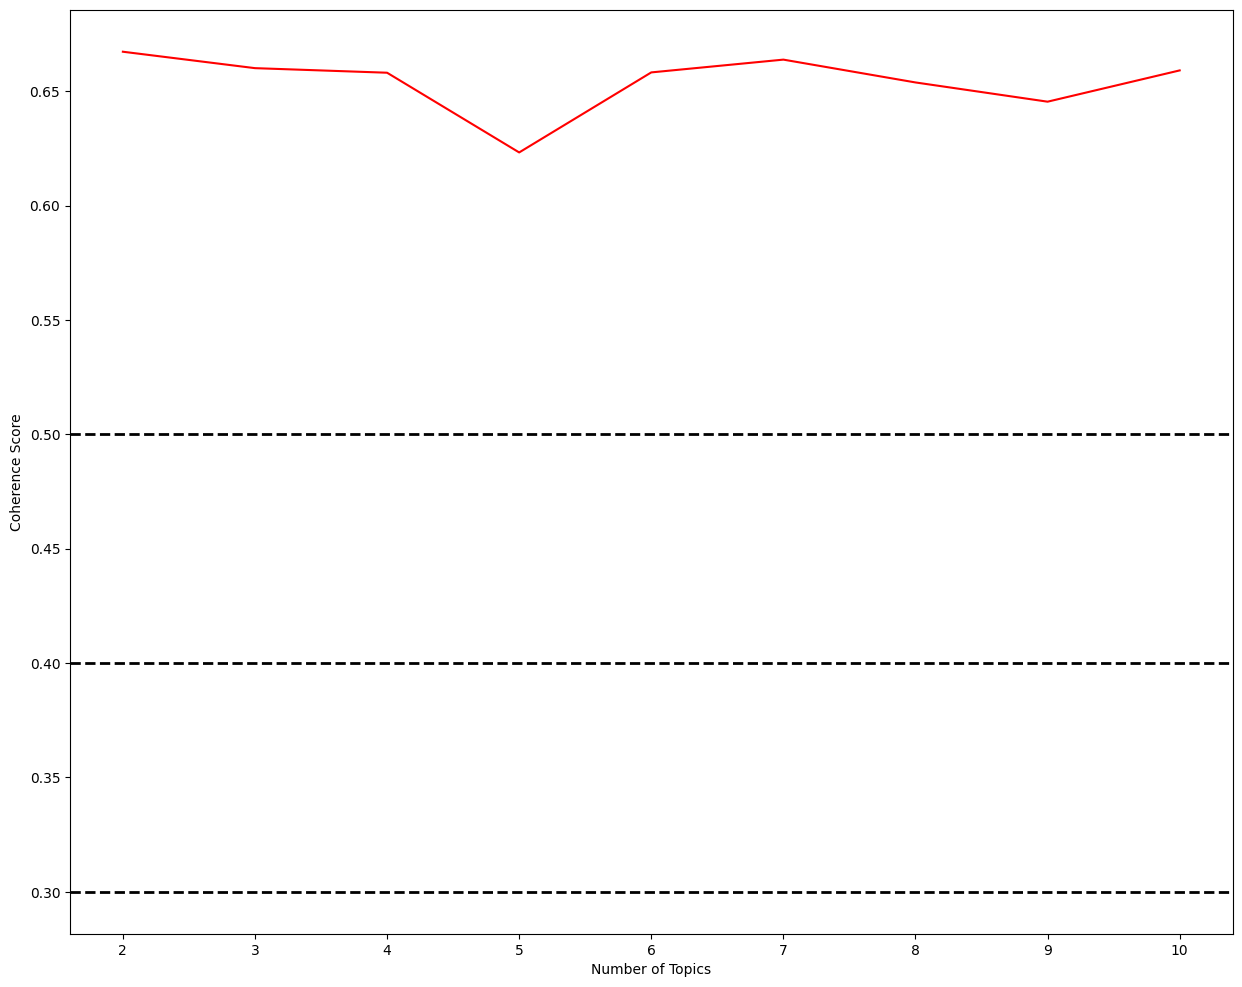

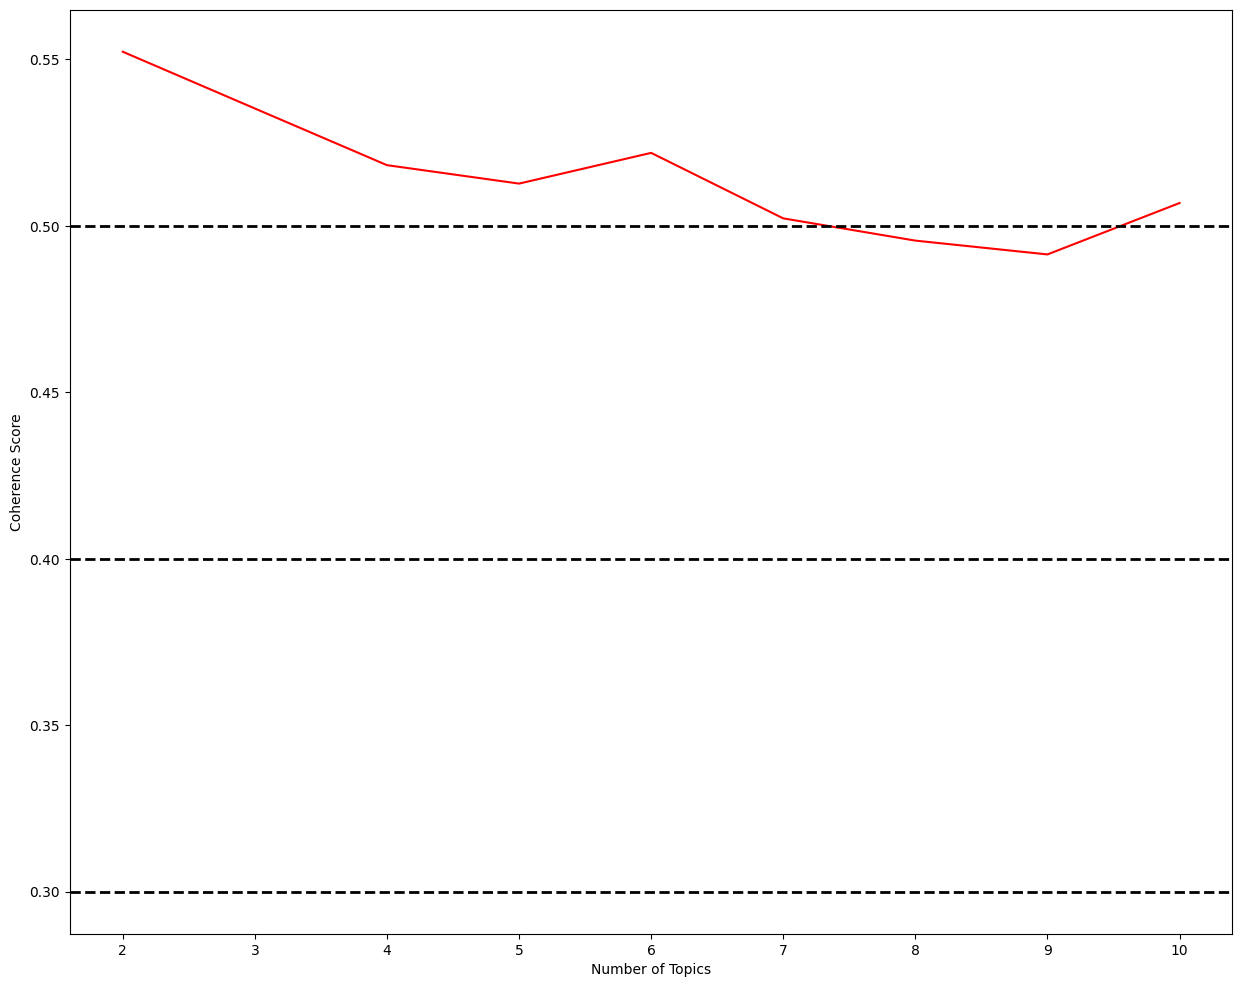


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:04<00:38,  4.78s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:33,  4.74s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
0.430*"smell" + -0.349*"service" + 0.295*"water" + 0.294*"toilet" + 0.285*"old" + -0.230*"change" + 0.210*"shower" + -0.209*"pay" + 0.187*"bathroom" + -0.145*"call" + -0.136*"star" + -0.134*"dirty" + -0.129*"request" + 0.125*"thing" + -0.115*"breakfast" + -0.104*"customer" + 0.096*"hot" + -0.095*"wait" + -0.092*"reception" + 0.087*"work"

Topic #3:
-0.465*"breakfast" + 0.393*"dirty" + 0.332*"towel" + 0.294*"change" + -0.275*"pay" + -0.192*"front" + -0.171*"call" + -0.158*"smell" + -0.135*"already" + -0.134*"tell" + 0.134*"charge" + -0.117*"price" + 0.108*"water" + -0.107*"old" + -0.107*"wait" + 0.105*"shower" + -0.102*"food" + -0.102*"try

 33%|████████████████████████████                                                        | 3/9 [00:14<00:28,  4.79s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

Topic #3:
0.465*"breakfast" + -0.393*"dirty" + -0.332*"towel" + -0.294*"change" + 0.275*"pay" + 0.192*"front" + 0.171*"call" + 0.158*"smell" + 0.135*"already" + 0.134*"tell" + -0.134*"charge" + 0.117*"price" + -0.108*"water" + 0.107*"old" + 0.107*"wait" + -0.105*"shower" + 0.102*"food" + 0.102*"try" + -0.0

 44%|█████████████████████████████████████▎                                              | 4/9 [00:19<00:24,  4.94s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
0.430*"smell" + -0.349*"service" + 0.295*"water" + 0.294*"toilet" + 0.285*"old" + -0.230*"change" + 0.210*"shower" + -0.209*"pay" + 0.187*"bathroom" + -0.145*"call" + -0.136*"star" + -0.134*"dirty" + -0.129*"request" + 0.125*"thing" + -0.115*"breakfast" + -0.104*"customer" + 0.096*"hot" + -0.095*"wait" + -0.092*"reception" + 0.087*"work"

Topic #3:
-0.465*"breakfast" + 0.393*"dirty" + 0.332*"towel" + 0.294*"change" + -0.275*"pay" + -0.192*"front" + -0.171*"call" + -0.158*"smell" + -0.135*"already" + -0.134*"tell" + 0.134*"charge" + -0.117*"price" + 0.108*"water" + -0.107*"old" + -0.107*"wait" + 0.105*"shower" + -0.102*"food" + -0.102*"try

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:25<00:21,  5.33s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

Topic #3:
0.465*"breakfast" + -0.393*"dirty" + -0.332*"towel" + -0.294*"change" + 0.275*"pay" + 0.192*"front" + 0.171*"call" + 0.158*"smell" + 0.135*"already" + 0.134*"tell" + -0.134*"charge" + 0.117*"price" + -0.108*"water" + 0.107*"old" + 0.107*"wait" + -0.105*"shower" + 0.102*"food" + 0.102*"try" + -0.0

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:30<00:15,  5.24s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

Topic #3:
0.465*"breakfast" + -0.393*"dirty" + -0.332*"towel" + -0.294*"change" + 0.275*"pay" + 0.192*"front" + 0.171*"call" + 0.158*"smell" + 0.135*"already" + 0.134*"tell" + -0.134*"charge" + 0.117*"price" + -0.108*"water" + 0.107*"old" + 0.107*"wait" + -0.105*"shower" + 0.102*"food" + 0.102*"try" + -0.0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:35<00:10,  5.12s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

Topic #3:
0.465*"breakfast" + -0.393*"dirty" + -0.332*"towel" + -0.294*"change" + 0.275*"pay" + 0.192*"front" + 0.171*"call" + 0.158*"smell" + 0.135*"already" + 0.134*"tell" + -0.134*"charge" + 0.117*"price" + -0.108*"water" + 0.107*"old" + 0.107*"wait" + -0.105*"shower" + 0.102*"food" + 0.102*"try" + -0.0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:40<00:05,  5.09s/it]

Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

Topic #3:
0.465*"breakfast" + -0.393*"dirty" + -0.332*"towel" + -0.294*"change" + 0.275*"pay" + 0.192*"front" + 0.171*"call" + 0.158*"smell" + 0.135*"already" + 0.134*"tell" + -0.134*"charge" + 0.117*"price" + -0.108*"water" + 0.107*"old" + 0.107*"wait" + -0.105*"shower" + 0.102*"food" + 0.102*"try" + -0.0

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.05s/it]


Topic #1:
0.290*"service" + 0.233*"water" + 0.207*"change" + 0.205*"reception" + 0.199*"dirty" + 0.186*"smell" + 0.177*"look" + 0.171*"breakfast" + 0.170*"toilet" + 0.157*"towel" + 0.149*"bathroom" + 0.146*"pay" + 0.140*"shower" + 0.133*"call" + 0.132*"old" + 0.132*"singapore" + 0.129*"find" + 0.127*"request" + 0.125*"front" + 0.120*"price"

Topic #2:
-0.430*"smell" + 0.349*"service" + -0.295*"water" + -0.294*"toilet" + -0.285*"old" + 0.230*"change" + -0.210*"shower" + 0.209*"pay" + -0.187*"bathroom" + 0.145*"call" + 0.136*"star" + 0.134*"dirty" + 0.129*"request" + -0.125*"thing" + 0.115*"breakfast" + 0.104*"customer" + -0.096*"hot" + 0.095*"wait" + 0.092*"reception" + -0.087*"work"

Topic #3:
0.465*"breakfast" + -0.393*"dirty" + -0.332*"towel" + -0.294*"change" + 0.275*"pay" + 0.192*"front" + 0.171*"call" + 0.158*"smell" + 0.135*"already" + 0.134*"tell" + -0.134*"charge" + 0.117*"price" + -0.108*"water" + 0.107*"old" + 0.107*"wait" + -0.105*"shower" + 0.102*"food" + 0.102*"try" + -0.0

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:03<00:29,  3.66s/it]

Topic #1:
0.025*"bathroom" + 0.024*"old" + 0.023*"water" + 0.023*"shower" + 0.022*"towel" + 0.021*"toilet" + 0.019*"smell" + 0.019*"look" + 0.019*"pay" + 0.018*"light" + 0.018*"breakfast" + 0.017*"service" + 0.017*"dirty" + 0.016*"food" + 0.016*"sleep" + 0.015*"request" + 0.015*"wall" + 0.014*"facility" + 0.014*"pool" + 0.013*"much"

Topic #2:
0.036*"service" + 0.030*"smell" + 0.027*"nothing" + 0.025*"price" + 0.021*"breakfast" + 0.021*"reception" + 0.020*"find" + 0.019*"water" + 0.018*"little" + 0.018*"dirty" + 0.017*"call" + 0.016*"work" + 0.015*"feel" + 0.014*"bathroom" + 0.014*"many" + 0.014*"look" + 0.014*"change" + 0.014*"provide" + 0.013*"singapore" + 0.013*"charge"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:07<00:24,  3.50s/it]

Topic #1:
0.035*"smell" + 0.034*"nothing" + 0.030*"water" + 0.027*"find" + 0.024*"light" + 0.022*"dirty" + 0.022*"food" + 0.022*"sleep" + 0.021*"reception" + 0.020*"feel" + 0.020*"breakfast" + 0.020*"price" + 0.019*"change" + 0.018*"towel" + 0.018*"recommend" + 0.017*"first" + 0.017*"service" + 0.017*"really" + 0.017*"thing" + 0.016*"toilet"

Topic #2:
0.041*"bathroom" + 0.035*"service" + 0.027*"smell" + 0.025*"shower" + 0.024*"money" + 0.023*"water" + 0.021*"walk" + 0.020*"work" + 0.020*"reception" + 0.020*"toilet" + 0.019*"little" + 0.018*"price" + 0.017*"wall" + 0.016*"use" + 0.016*"dirty" + 0.016*"look" + 0.015*"next" + 0.015*"poor" + 0.014*"enough" + 0.014*"breakfast"

Topic #3:
0.032*"pay" + 0.027*"star" + 0.026*"old" + 0.026*"wait" + 0.024*"breakfast" + 0.024*"service" + 0.024*"look" + 0.022*"request" + 0.022*"charge" + 0.021*"experience" + 0.021*"towel" + 0.020*"luggage" + 0.018*"tell" + 0.018*"pool" + 0.017*"quite" + 0.016*"toilet" + 0.016*"helpful" + 0.015*"close" + 0.015*"pr

 33%|████████████████████████████                                                        | 3/9 [00:10<00:20,  3.38s/it]

Topic #1:
0.042*"nothing" + 0.030*"use" + 0.027*"look" + 0.027*"work" + 0.026*"old" + 0.024*"experience" + 0.023*"recommend" + 0.022*"light" + 0.022*"cleanliness" + 0.021*"expensive" + 0.020*"many" + 0.019*"water" + 0.019*"little" + 0.019*"charge" + 0.019*"far" + 0.018*"towel" + 0.016*"iron" + 0.016*"smell" + 0.016*"toilet" + 0.016*"walk"

Topic #2:
0.064*"service" + 0.038*"pay" + 0.032*"reception" + 0.031*"wait" + 0.028*"smell" + 0.027*"call" + 0.026*"customer" + 0.024*"front" + 0.024*"tell" + 0.022*"light" + 0.022*"already" + 0.021*"dirty" + 0.019*"lot" + 0.017*"breakfast" + 0.016*"mind" + 0.016*"provide" + 0.016*"request" + 0.015*"find" + 0.015*"desk" + 0.015*"star"

Topic #3:
0.046*"water" + 0.044*"shower" + 0.044*"bathroom" + 0.032*"wall" + 0.028*"towel" + 0.021*"outside" + 0.020*"request" + 0.019*"smell" + 0.018*"star" + 0.018*"lobby" + 0.018*"little" + 0.017*"toilet" + 0.017*"sleep" + 0.017*"want" + 0.017*"luggage" + 0.016*"put" + 0.016*"look" + 0.016*"dirty" + 0.016*"breakfast"

 44%|█████████████████████████████████████▎                                              | 4/9 [00:13<00:16,  3.26s/it]

Topic #1:
0.052*"pay" + 0.047*"light" + 0.034*"wait" + 0.034*"tell" + 0.031*"already" + 0.029*"reception" + 0.026*"smell" + 0.026*"charge" + 0.026*"another" + 0.024*"star" + 0.024*"way" + 0.021*"hear" + 0.021*"price" + 0.021*"request" + 0.021*"noise" + 0.021*"see" + 0.019*"water" + 0.018*"find" + 0.018*"call" + 0.018*"luggage"

Topic #2:
0.038*"service" + 0.032*"money" + 0.031*"toilet" + 0.030*"bathroom" + 0.029*"much" + 0.025*"really" + 0.024*"wall" + 0.022*"look" + 0.022*"enough" + 0.021*"everything" + 0.021*"next" + 0.020*"expensive" + 0.019*"price" + 0.019*"hear" + 0.018*"feel" + 0.018*"smell" + 0.018*"find" + 0.018*"big" + 0.016*"towel" + 0.016*"customer"

Topic #3:
0.038*"price" + 0.037*"bathroom" + 0.035*"sleep" + 0.032*"recommend" + 0.029*"experience" + 0.028*"helpful" + 0.024*"old" + 0.024*"feel" + 0.022*"star" + 0.019*"facility" + 0.019*"little" + 0.018*"look" + 0.018*"use" + 0.018*"morning" + 0.017*"friendly" + 0.016*"lobby" + 0.016*"high" + 0.015*"much" + 0.015*"cleanliness

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:16<00:12,  3.18s/it]

Topic #1:
0.037*"change" + 0.035*"nothing" + 0.031*"service" + 0.030*"light" + 0.026*"price" + 0.025*"really" + 0.025*"feel" + 0.025*"breakfast" + 0.022*"front" + 0.021*"towel" + 0.020*"use" + 0.019*"toilet" + 0.018*"water" + 0.018*"call" + 0.018*"put" + 0.018*"little" + 0.017*"smell" + 0.017*"request" + 0.017*"desk" + 0.017*"far"

Topic #2:
0.043*"pay" + 0.041*"money" + 0.031*"water" + 0.029*"service" + 0.029*"already" + 0.025*"bathroom" + 0.024*"breakfast" + 0.024*"provide" + 0.022*"poor" + 0.022*"big" + 0.020*"front" + 0.020*"end" + 0.020*"old" + 0.020*"enough" + 0.020*"lobby" + 0.019*"another" + 0.018*"wait" + 0.018*"request" + 0.018*"star" + 0.018*"wall"

Topic #3:
0.069*"smell" + 0.053*"shower" + 0.047*"work" + 0.033*"toilet" + 0.033*"bathroom" + 0.029*"towel" + 0.025*"find" + 0.020*"enough" + 0.019*"water" + 0.019*"wall" + 0.018*"request" + 0.018*"pool" + 0.018*"still" + 0.018*"quite" + 0.016*"old" + 0.016*"hear" + 0.016*"window" + 0.016*"people" + 0.016*"use" + 0.016*"next"

To

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:19<00:09,  3.16s/it]

Topic #1:
0.054*"breakfast" + 0.039*"nothing" + 0.036*"pool" + 0.029*"water" + 0.025*"pay" + 0.024*"look" + 0.022*"though" + 0.022*"price" + 0.021*"reception" + 0.021*"star" + 0.020*"service" + 0.020*"call" + 0.020*"close" + 0.017*"already" + 0.017*"use" + 0.017*"think" + 0.015*"request" + 0.015*"front" + 0.015*"tell" + 0.015*"sleep"

Topic #2:
0.048*"service" + 0.046*"bathroom" + 0.045*"change" + 0.041*"smell" + 0.033*"shower" + 0.028*"water" + 0.027*"towel" + 0.027*"nothing" + 0.022*"toilet" + 0.020*"dirty" + 0.020*"customer" + 0.020*"space" + 0.020*"put" + 0.018*"really" + 0.018*"window" + 0.017*"lobby" + 0.017*"helpful" + 0.017*"outside" + 0.015*"look" + 0.015*"luggage"

Topic #3:
0.039*"reception" + 0.030*"request" + 0.030*"experience" + 0.028*"service" + 0.028*"everything" + 0.026*"money" + 0.026*"pay" + 0.026*"due" + 0.024*"towel" + 0.024*"front" + 0.022*"dirty" + 0.022*"wall" + 0.022*"desk" + 0.022*"call" + 0.020*"price" + 0.020*"provide" + 0.017*"breakfast" + 0.017*"wait" + 0.

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:22<00:06,  3.14s/it]

Topic #1:
0.059*"service" + 0.048*"star" + 0.036*"wait" + 0.031*"call" + 0.031*"breakfast" + 0.031*"money" + 0.029*"price" + 0.029*"much" + 0.027*"experience" + 0.024*"pay" + 0.022*"expect" + 0.022*"front" + 0.019*"reception" + 0.019*"look" + 0.019*"desk" + 0.019*"nothing" + 0.019*"due" + 0.019*"another" + 0.017*"never" + 0.017*"singapore"

Topic #2:
0.083*"breakfast" + 0.051*"food" + 0.039*"many" + 0.030*"smell" + 0.024*"old" + 0.024*"feel" + 0.021*"walk" + 0.021*"bathroom" + 0.021*"see" + 0.021*"cleanliness" + 0.021*"everything" + 0.018*"water" + 0.018*"quite" + 0.018*"look" + 0.018*"pool" + 0.015*"little" + 0.015*"far" + 0.015*"enough" + 0.015*"people" + 0.015*"phone"

Topic #3:
0.039*"bathroom" + 0.034*"look" + 0.034*"old" + 0.034*"dirty" + 0.028*"pay" + 0.025*"water" + 0.023*"smell" + 0.023*"change" + 0.023*"toilet" + 0.023*"price" + 0.020*"enough" + 0.019*"reception" + 0.018*"stain" + 0.017*"towel" + 0.017*"expensive" + 0.015*"hear" + 0.015*"really" + 0.015*"outside" + 0.015*"big

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:25<00:03,  3.11s/it]

Topic #1:
0.066*"smell" + 0.048*"change" + 0.039*"food" + 0.036*"breakfast" + 0.030*"really" + 0.027*"experience" + 0.027*"find" + 0.027*"front" + 0.027*"feel" + 0.024*"toilet" + 0.021*"water" + 0.021*"recommend" + 0.021*"light" + 0.018*"service" + 0.018*"poor" + 0.018*"towel" + 0.018*"never" + 0.018*"helpful" + 0.018*"money" + 0.018*"window"

Topic #2:
0.095*"service" + 0.039*"pay" + 0.029*"toilet" + 0.026*"price" + 0.026*"water" + 0.021*"customer" + 0.021*"lot" + 0.021*"recommend" + 0.019*"call" + 0.019*"see" + 0.019*"food" + 0.017*"wait" + 0.017*"cold" + 0.015*"dirty" + 0.015*"money" + 0.015*"sleep" + 0.015*"outside" + 0.015*"far" + 0.015*"feel" + 0.015*"still"

Topic #3:
0.049*"really" + 0.039*"front" + 0.034*"sleep" + 0.034*"much" + 0.034*"option" + 0.029*"wall" + 0.029*"call" + 0.029*"mind" + 0.025*"nothing" + 0.025*"put" + 0.025*"money" + 0.025*"reception" + 0.020*"toilet" + 0.020*"towel" + 0.020*"light" + 0.020*"star" + 0.020*"change" + 0.020*"worth" + 0.020*"expensive" + 0.015

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.20s/it]

Topic #1:
0.038*"really" + 0.035*"breakfast" + 0.033*"sleep" + 0.028*"wall" + 0.028*"use" + 0.024*"dirty" + 0.024*"smell" + 0.024*"front" + 0.024*"work" + 0.024*"find" + 0.024*"want" + 0.021*"shower" + 0.021*"reception" + 0.021*"toilet" + 0.021*"hear" + 0.021*"put" + 0.018*"service" + 0.018*"thing" + 0.018*"experience" + 0.018*"water"

Topic #2:
0.046*"work" + 0.044*"option" + 0.032*"service" + 0.032*"food" + 0.029*"iron" + 0.029*"much" + 0.028*"toilet" + 0.026*"light" + 0.023*"water" + 0.023*"shower" + 0.023*"cleanliness" + 0.021*"price" + 0.021*"space" + 0.021*"breakfast" + 0.018*"dirty" + 0.018*"reception" + 0.018*"disappoint" + 0.018*"hot" + 0.018*"money" + 0.018*"little"

Topic #3:
0.037*"cold" + 0.034*"walk" + 0.034*"quite" + 0.030*"next" + 0.027*"people" + 0.024*"water" + 0.024*"little" + 0.024*"wall" + 0.020*"look" + 0.020*"light" + 0.020*"enough" + 0.020*"hear" + 0.020*"pool" + 0.017*"nothing" + 0.017*"service" + 0.017*"bathroom" + 0.017*"breakfast" + 0.017*"find" + 0.017*"lot

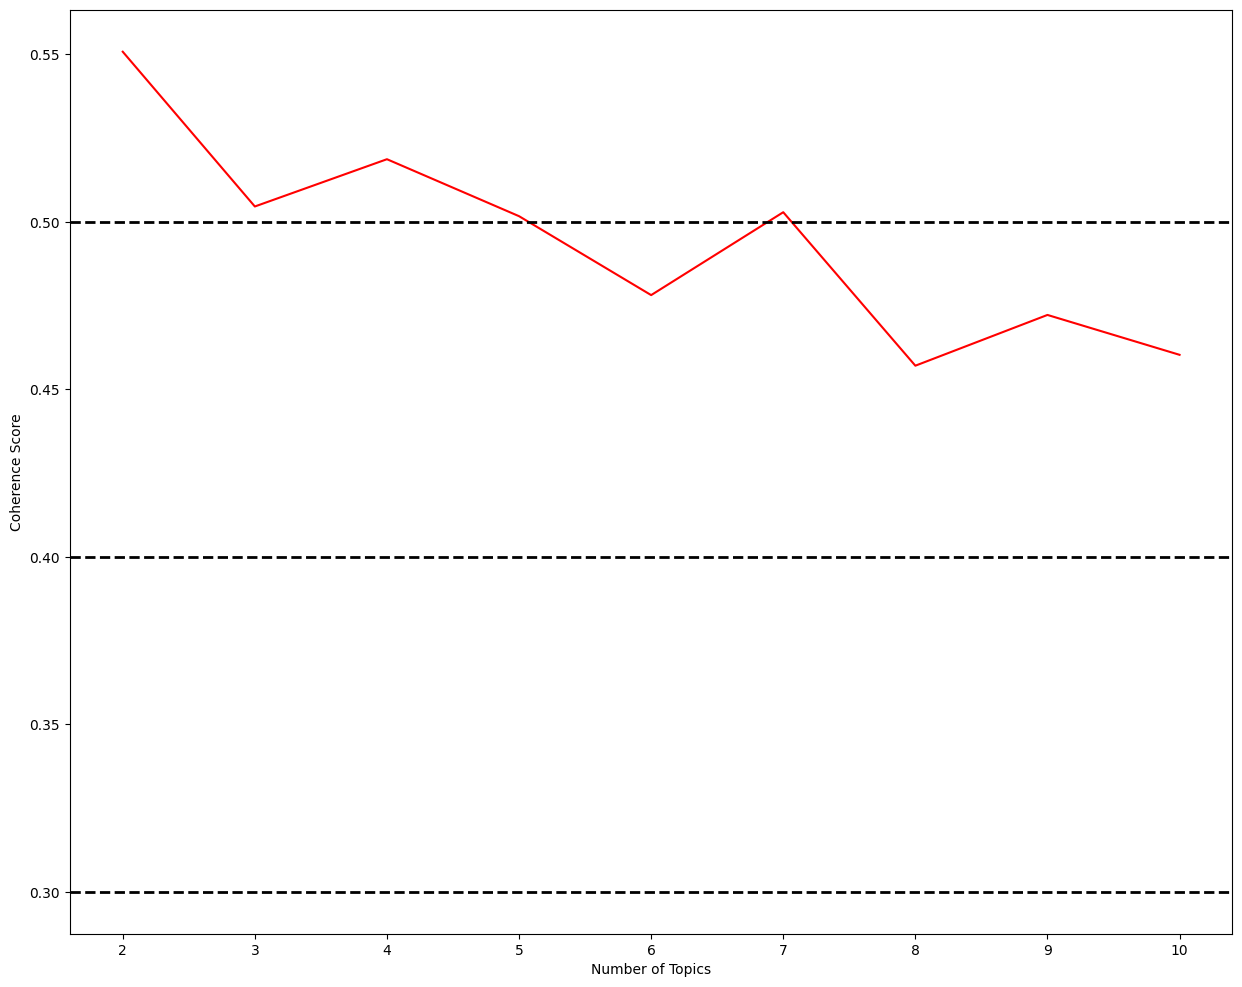

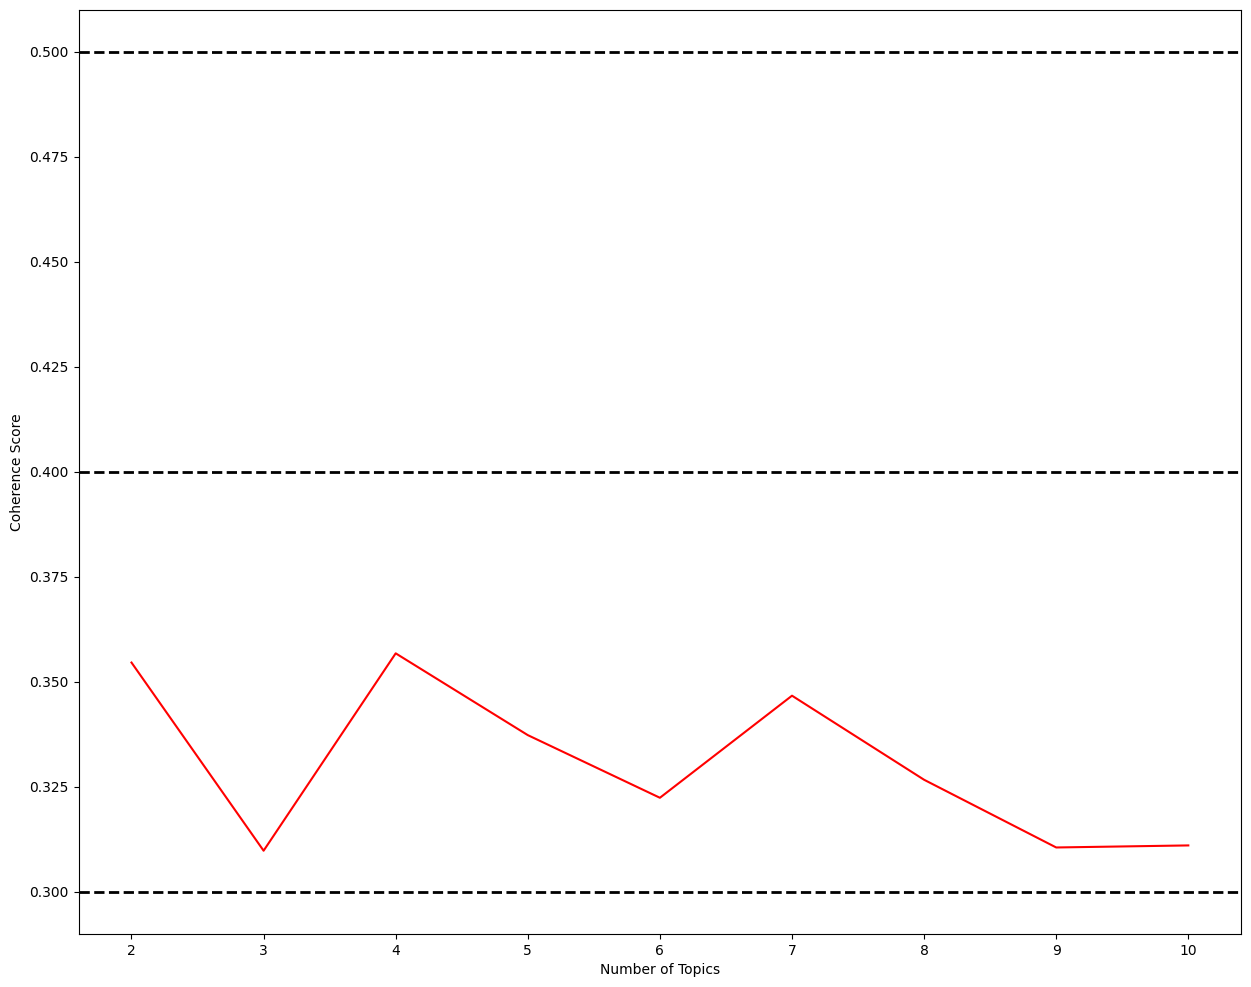

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v3"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.667260,df_pos
1,LSI,3,0.660077,df_pos
2,LSI,4,0.658079,df_pos
3,LSI,5,0.623225,df_pos
4,LSI,6,0.658220,df_pos
5,LSI,7,0.663805,df_pos
6,LSI,8,0.653828,df_pos
7,LSI,9,0.645417,df_pos
8,LSI,10,0.659091,df_pos
0,LDA,2,0.552269,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.550753,df_neg
1,LSI,2,0.667260,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 2

Topic 1: service, water, change, reception, dirty, smell, look, breakfast, toilet, towel

Topic 2: smell, service, water, toilet, old, change, shower, pay, bathroom, call

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 2

Topic 1: great, station, breakfast, food, friendly, singapore, water, provide, service, helpful

Topic 2: great, water, call, provide, want, friendly, tell, reception, station, quite

----------



In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-27 00:12:22.727979
Text processing spent 0:09:28.160730
